In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
wine = pd.read_csv("./data/winequality-red.csv",sep=";")

scaler = StandardScaler()
wine_std = pd.DataFrame(scaler.fit_transform(wine), columns=wine.columns)

def split_train_test(data, test_ratio):
    np.random.seed(0)
    shuffled_index = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_index = shuffled_index[:test_size]
    train_index = shuffled_index[test_size:]
    return data.iloc[train_index], data.iloc[test_index]

train_set, test_set = split_train_test(wine_std, 0.2)
print("train size: ",len(train_set)," test size: ",len(test_set))

X_train = train_set["fixed acidity"]
T_train = train_set["pH"]
X_test = test_set["fixed acidity"]
T_test = test_set["pH"]


train size:  1280  test size:  319


In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array

In [7]:
class polyreg_ridge(BaseEstimator, RegressorMixin):
    def __init__(self, degree, lam):
        self.degree = degree
        self.lam = lam
        self.w_ = None
        
    def fit(self, x, y):
        if type(x) is pd.Series:
            x = x.values.reshape(-1,1)
        else: 
            x = x.reshape(-1,1)
            
        x, y = check_X_y(x, y, y_numeric=True)
        if self.lam != 0:
            pass
        else:
            pass
        
        x_pow = []
        xx = x.reshape(len(x),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        XXX = np.c_[np.ones(mat.shape[0]),mat]
        I = np.eye(XXX.shape[1])
        A = XXX.T@XXX + self.lam * I
        b = XXX.T@y
        self.w_ = np.dot(np.linalg.inv(A),b)
        
        return self
    
    def predict(self, x):
        if type(x) is pd.Series:
            x = x.values.reshape(-1,1)
        else: 
            x = x.reshape(-1,1)
        
        x_pow = []
        xx = x.reshape(len(x),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        XX = np.c_[np.ones(mat.shape[0]),mat]
        y = np.dot(XX,self.w_)
        
        check_is_fitted(self, "w_") 
        XX = check_array(XX)
        return y
        

In [8]:
poly = polyreg_ridge(10,1.)
poly.fit(X_train, T_train)
print("係数: ",poly.w_)

係数:  [-2.15088198e-01 -5.23083881e-01  5.33656193e-01 -3.14099270e-01
 -2.79125105e-01  1.50111078e-01  6.87612332e-02 -3.83570371e-02
 -2.11624504e-03  2.91189414e-03 -3.32287714e-04]


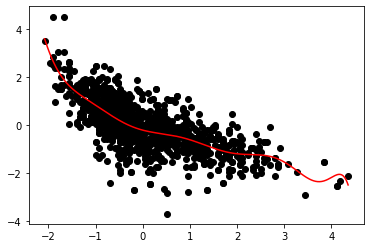

In [9]:
plt.scatter(X_train, T_train, color="k")
xx = np.linspace(X_train.min(), X_train.max(), 300)
plt.plot(xx, poly.predict(xx), color="r")

In [12]:
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

# Grid search
parameters = {'lam':np.exp([i for i in range(-30,30)])}
reg = GridSearchCV(polyreg_ridge(10, 1.0),parameters,cv=5)
reg.fit(X_train,T_train)
best = reg.best_estimator_

# 決定係数
print("決定係数: ", best.score(X_train, T_train)) 
# lambda
print("lam: ", best.lam)

決定係数:  0.5168256612666384
lam:  20.085536923187668


In [13]:
class linear(BaseEstimator, RegressorMixin):
    def __init__(self, degree):
        self.degree = degree
        self.w_ = None
        
    def fit(self, x, y):
        if type(x) is pd.Series:
            x = x.values.reshape(-1,1)
        else: 
            x = x.reshape(-1,1)
            
        x, y = check_X_y(x, y, y_numeric=True)
        
        x_pow = []
        xx = x.reshape(len(x),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        XXX = np.c_[np.ones(mat.shape[0]),mat]
        I = np.eye(XXX.shape[1])
        A = XXX.T@XXX
        b = XXX.T@y
        self.w_ = np.dot(np.linalg.inv(A),b)
        
        return self
    
    def predict(self, x):
        if type(x) is pd.Series:
            x = x.values.reshape(-1,1)
        else: 
            x = x.reshape(-1,1)
        
        x_pow = []
        xx = x.reshape(len(x),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        XX = np.c_[np.ones(mat.shape[0]),mat]
        y = np.dot(XX,self.w_)
        
        check_is_fitted(self, "w_") 
        XX = check_array(XX)
        return y
        

In [28]:
def soft_thresholding(x, y):
        return np.sign(x) * max(abs(x) - y, 0)
    

class Lasso(BaseEstimator, RegressorMixin):
    def __init__(self, degree, lam, tol=0.001, max_iter=1000):
        self.lambda_ = lam
        self.degree = degree
        self.tol = tol
        self.max_iter = max_iter
        self.w_ = None
        
    def _update(self, row, col, X, t):
        self.w_[0] = (t - np.dot(X, self.w_[1:])).sum() / row
        w0vec = np.ones(row) * self.w_[0]
        for k in range(col):
            ww = self.w_[1:]
            ww[k] = 0
            q = np.dot(t - w0vec - np.dot(X, ww), X[:,k])
            r = np.dot(X[:,k], X[:,k])
            self.w_[k+1] = soft_thresholding(q / r, self.lambda_)
        
    def fit(self, X, y):
        if type(X) is pd.Series:
            X = X.values.reshape(-1,1)
        else: 
            X = X.reshape(-1,1)
            
        X, y = check_X_y(X, y, y_numeric=True)
        if self.lambda_ != 0:
            pass
        else:
            pass
        
        x_pow = []
        xx = X.reshape(len(X),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        row, col = mat.shape
        self.w_ = np.zeros(col + 1)
        avgl1 = 0.
        
        for _ in range(self.max_iter):
            avgl1_prev = avgl1
            self._update(row, col, mat, y)
            avgl1 = np.abs(self.w_).sum() / self.w_.shape[0]
            if abs(avgl1 - avgl1_prev) <= self.tol:
                break
    
    def predict(self, X):
        if type(X) is pd.Series:
            X = X.values.reshape(-1,1)
        else: 
            X = X.reshape(-1,1)
        
        x_pow = []
        xx = X.reshape(len(X),1)
        for i in range(1, self.degree + 1):
            x_pow.append(xx**i)
            
        mat = np.concatenate(x_pow, axis=1)
        
        XX = np.c_[np.ones(mat.shape[0]),mat]
        y = np.dot(XX,self.w_)
        
        check_is_fitted(self, "w_") 
        XX = check_array(XX)
        return y

In [29]:
np.random.seed(42)
sample = 20
dim = 20
eps = np.random.randn(sample) / 2.5
x2 = np.linspace(-5,5,sample)
y2 = np.sin(x2 + eps) #### eps

In [31]:
linear_reg = linear(dim)
linear_reg.fit(x2, y2)
print("係数: ",linear_reg.w_)

poly2_r = polyreg_ridge(dim,100.)
poly2_r.fit(x2, y2)
print("ridge 係数: ",poly2_r.w_)

lasso = Lasso(dim,1e-5)
lasso.fit(x2,y2)
print("lasso 係数: ",lasso.w_)

係数:  [-7.37879828e+00 -8.77168036e+00  1.68563306e+00  2.19151611e+01
 -2.67130375e+00 -2.43810062e+01  2.91705418e+00  1.21635370e+01
 -1.44910192e+00 -3.18662047e+00  3.79148036e-01  4.74776924e-01
 -5.64799905e-02 -4.14058864e-02  4.92680725e-03  2.08042422e-03
 -2.47628341e-04 -5.54916187e-05  6.60724072e-06  6.05874618e-07
 -7.21612068e-08]
ridge 係数:  [ 5.71176857e-04  2.67800944e-02 -6.29726895e-04  3.26760013e-02
 -2.23696479e-05  3.91767699e-02 -1.13234649e-03  2.81516737e-02
 -2.07468265e-03 -1.83214678e-02  1.66799161e-03  3.74414292e-03
 -4.08099715e-04 -3.76409933e-04  4.68481421e-05  2.02520880e-05
 -2.78489070e-06 -5.58259336e-07  8.28728546e-08  6.18638034e-09
 -9.74753307e-10]
<class 'float'>
lasso 係数:  [ 1.28468802e-02  3.87054624e-02 -1.79794508e-04 -8.04107829e-03
 -0.00000000e+00 -6.85082469e-05  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.0000000

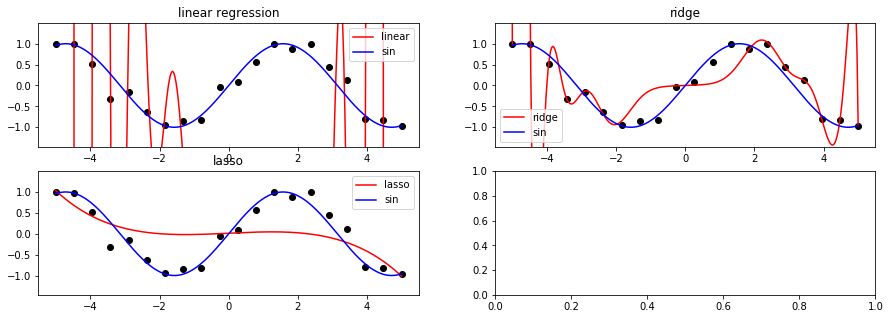

In [32]:
plt.rcParams['figure.figsize'] = (15 ,5)
fig, axs = plt.subplots(2,2)

xx2 = np.linspace(-5, 5, 300)
yy2 = np.sin(xx2)

ymin_lim = y2.min() - 0.5
ymax_lim = y2.max() + 0.5
xmin_lim = x2.min() - 0.5
xmax_lim = x2.max() + 0.5

axs[0,0].set_title("linear regression")
axs[0,1].set_title("ridge")
axs[1,0].set_title("lasso")
axs[1,0].set_title("lasso")
axs[0,0].plot(xx2, linear_reg.predict(xx2), color="r", label="linear")
axs[0,1].plot(xx2, poly2_r.predict(xx2), color="r", label="ridge")
axs[1,0].plot(xx2, lasso.predict(xx2), color="r", label="lasso")

j = 0
for i in range(3):
    if i == 2:
        i = 0
        j = 1
    axs[j,i].set_xlim((xmin_lim, xmax_lim))
    axs[j,i].set_ylim((ymin_lim, ymax_lim))
    axs[j,i].scatter(x2, y2, color="k")
    axs[j,i].plot(xx2, yy2, color="b", label="sin")
    axs[j,i].legend()
